**Main imports**

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((.5,.5,.5),(.5,.5,.5))
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

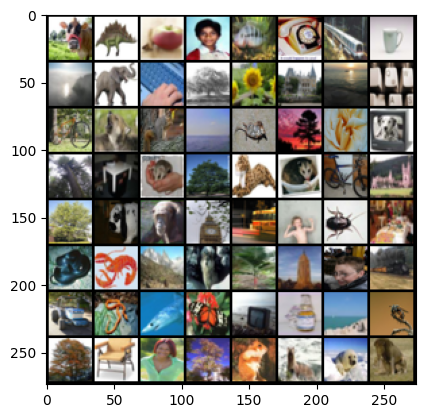

In [3]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**This is an autoencoder pretending to be a generative model**

In [4]:
import torch.nn.init as init

# Generator
class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(params['n_latent'], 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, params['n_channels'], kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        # Initialize weights
        self.apply(initialize_weights)

    def forward(self, z):
        return self.model(z)
    
    def sample(self,z):
        with torch.no_grad():
            generated_samples = self(z)
        return generated_samples

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(params['n_channels'], 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
        )
        # Initialize weights
        self.apply(initialize_weights)

    def forward(self, x):
        return self.model(x)

# Weight initialization function
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1.0, std=0.02)
        init.constant_(m.bias.data, 0.0)

# Hyperparameters
params = {
    'batch_size': train_loader.batch_size,
    'n_channels': 3,
    'n_latent': 10 # alters number of parameters
}

# Initialize Generator and Discriminator
G = Generator(params).to(device)
D = Discriminator(params).to(device)

# Print the number of model parameters
print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(G.parameters())) + len(torch.nn.utils.parameters_to_vector(D.parameters()))}')
if len(torch.nn.utils.parameters_to_vector(G.parameters())) + len(torch.nn.utils.parameters_to_vector(D.parameters())) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# Initialize the optimizers
optimiser_G = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5,0.999))
optimiser_D = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5,0.999))
scheduler_G = StepLR(optimiser_G, step_size=1000, gamma=0.95)
scheduler_D = StepLR(optimiser_D, step_size=1000, gamma=0.95)



> Number of model parameters 929472


**Main training loop**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 50000, Generator Loss: 1.4148, Discriminator Loss: 1.2220, Learning Rate: 0.000154


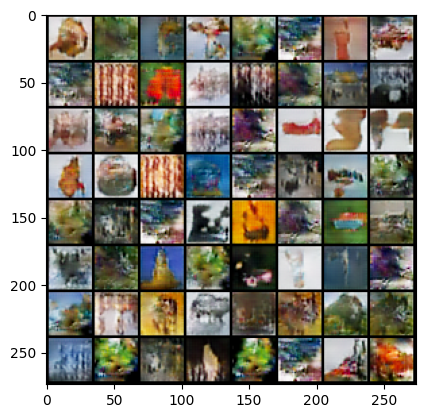

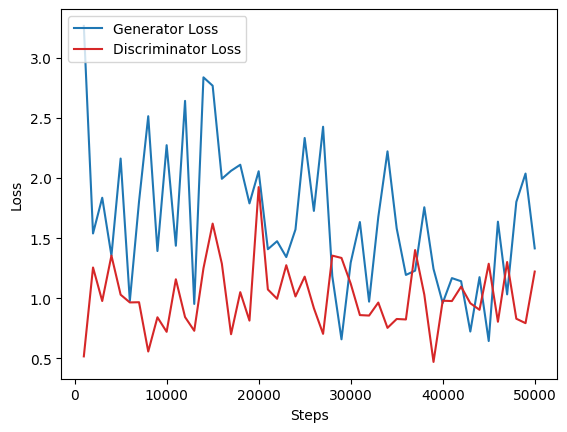

In [10]:
# Function to generate noise for the generator
def generate_noise(params):
    return torch.randn(params['batch_size'], params['n_latent'], 1, 1).to(device)

# Loss function
criterion = nn.BCELoss()

# Arrays for metrics
plot_data = []

steps = 0
# Training loop
while steps < 50000:
    for i in range(1000):
        real_data, t = next(train_iterator) 
        real_images = real_data.to(device)

        # Train Discriminator
        optimiser_D.zero_grad()

        # Real data
        real_outputs = D(real_images).squeeze()  # Squeeze singleton dimensions
        real_labels = torch.ones_like(real_outputs).to(device)
        loss_real = criterion(real_outputs, real_labels)

        # Fake data
        noise = generate_noise(params)
        fake_images = G(noise)
        fake_outputs = D(fake_images.detach()).squeeze()  # Squeeze singleton dimensions
        fake_labels = torch.zeros_like(fake_outputs).to(device)
        loss_fake = criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimiser_D.step()

        # Train Generator
        optimiser_G.zero_grad()

        # Generate fake data
        noise = generate_noise(params)
        generated_images = G(noise)
        fake_outputs = D(generated_images).squeeze()

        # Generator loss
        labels = torch.ones_like(fake_outputs).to(device).squeeze()
        loss_G = criterion(fake_outputs, labels)

        # Backpropagate and optimize
        loss_G.backward()
        optimiser_G.step()
        
        scheduler_D.step()
        scheduler_G.step()
        steps += 1

    # Evaluation at the end of each epoch
    with torch.no_grad():
        # Print your evaluation metrics
        print("Step {}, Generator Loss: {:.4f}, Discriminator Loss: {:.4f}, Learning Rate: {:.6f}".format(steps, loss_G.item(), loss_D.item(), optimiser_G.param_groups[0]["lr"]))
        fake_samples = G(generate_noise(params))
        plt.imshow(torchvision.utils.make_grid(fake_samples, nrow=8).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
        plt.show()
        # Plot your loss graph
        plot_data.append([steps, loss_G.item(), loss_D.item()])
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:blue', label="Generator Loss")
        plt.plot([x[0] for x in plot_data], [x[2] for x in plot_data], '-', color='tab:red', label="Discriminator Loss")
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend(loc="upper left")
        plt.show()
        plt.pause(0.1)
        disp.clear_output(wait=True)


In [33]:
# Save the generator and discriminator models
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')

In [5]:
# Define the generator and discriminator instances
G = Generator(params).to(device)
D = Discriminator(params).to(device)

# Load the saved state dicts
G.load_state_dict(torch.load('generator.pth'))
D.load_state_dict(torch.load('discriminator.pth'))

# Set the models to evaluation mode
G.eval()
D.eval()


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): S

**Latent interpolations**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


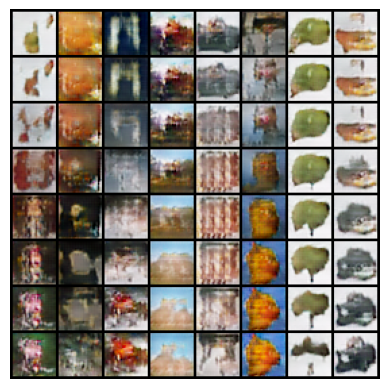

In [13]:
# Latent interpolations
z = torch.randn(params['batch_size'], params['n_latent'], 1, 1).to(device)

# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(params['batch_size']))

z0 = z[0:col_size].repeat(col_size, 1, 1, 1)  # z for top row
z1 = z[params['batch_size'] - col_size:].repeat(col_size, 1, 1, 1)  # z for bottom row

t = torch.linspace(0, 1, col_size).unsqueeze(1).repeat(1, col_size).view(params['batch_size'], 1, 1, 1).to(device)

lerp_z = (1 - t) * z0 + t * z1  # linearly interpolate between two points in the latent space
lerp_g = G.sample(lerp_z)  # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.axis('off')
int_image = torchvision.utils.make_grid(lerp_g)
plt.imshow(int_image.permute(1, 2, 0).cpu().numpy(), cmap=plt.cm.binary)
plt.show()

torchvision.utils.save_image(int_image, "int_grid.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


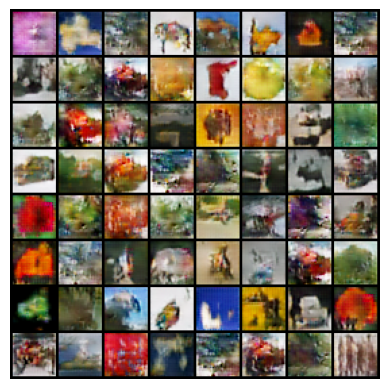

In [9]:
import torchvision.utils

# Generate 64 random latent vectors
z = torch.randn(64, params['n_latent'], 1, 1).to(device)

# Generate images in a single forward pass
generated_images = G.sample(z)

# Create a grid of generated images
grid_image = torchvision.utils.make_grid(generated_images, nrow=8, padding=2)

# Display the grid image
plt.imshow(grid_image.permute(1, 2, 0).cpu().numpy(), cmap=plt.cm.binary)
plt.axis('off')
plt.show()

# Save the grid image
torchvision.utils.save_image(grid_image, "generated_grid.png")


**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [12]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [13]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory} # remove any existing (old) data
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(params['batch_size'], params['n_latent'],1,1).to(device)
    samples_batch = G.sample(z).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [14]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

compute FID between two folders


/home2/frcg69/deeplearning_jupyterenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 10000 images in the folder real_images


FID real_images : 100%|██████████| 313/313 [00:57<00:00,  5.43it/s]


Found 10000 images in the folder generated_images


FID generated_images : 100%|██████████| 313/313 [00:55<00:00,  5.61it/s]


FID score: 94.53320514346706
